In [1]:
import numpy as np
import seaborn as sns
import torch
import random
import pathlib
import os
import glob
from scipy import io
import cv2
import math
from matplotlib import pyplot as plt
import pandas as pd
from skimage.transform import resize
import tqdm
import torch.nn.functional as F

from PraNet.utils.dataloader import test_dataset
from PraNet.lib.PraNet_Res2Net import PraNet
from skimage.filters import gaussian
from skimage.morphology import label as connected_components

In [2]:
def _prepare_patching(img, pred, gt_, window_size, mask_size, return_src_top_corner=False):
    """Prepare patch information for tile processing.
    Args:
        img: original input image
        window_size: input patch size
        mask_size: output patch size
        return_src_top_corner: whether to return coordiante information for top left corner of img
        
    """

    win_size = window_size
    msk_size = step_size = mask_size

    def get_last_steps(length, msk_size, step_size):
        nr_step = math.ceil((length - msk_size) / step_size)
        last_step = (nr_step + 1) * step_size
        return int(last_step), int(nr_step + 1)

    im_h = img.shape[0]
    im_w = img.shape[1]

    last_h, _ = get_last_steps(im_h, msk_size, step_size)
    last_w, _ = get_last_steps(im_w, msk_size, step_size)

    diff = win_size - step_size
    padt = padl = diff // 2
    padb = last_h + win_size - im_h
    padr = last_w + win_size - im_w

    img = np.lib.pad(img, ((padt, padb), (padl, padr), (0, 0)), "reflect")
    pred = np.lib.pad(pred, ((padt, padb), (padl, padr)), "reflect")
    gt_ = np.lib.pad(gt_, ((padt, padb), (padl, padr)), "reflect")
    
    # generating subpatches index from orginal
    coord_y = np.arange(0, last_h, step_size, dtype=np.int32)
    coord_x = np.arange(0, last_w, step_size, dtype=np.int32)
    row_idx = np.arange(0, coord_y.shape[0], dtype=np.int32)
    col_idx = np.arange(0, coord_x.shape[0], dtype=np.int32)
    coord_y, coord_x = np.meshgrid(coord_y, coord_x)
    row_idx, col_idx = np.meshgrid(row_idx, col_idx)
    coord_y = coord_y.flatten()
    coord_x = coord_x.flatten()
    row_idx = row_idx.flatten()
    col_idx = col_idx.flatten()
    #
    patch_info = np.stack([coord_y, coord_x, row_idx, col_idx], axis=-1)
    if not return_src_top_corner:
        return img, pred, gt_,patch_info
    else:
        return img, pred, gt_, patch_info, [padt, padl]

In [3]:
def fix_randomness(seed=0):
    np.random.seed(seed=seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    random.seed(seed)

In [4]:
# labels_path = glob.glob('/media/htic/_srv_Data/conformal_/hover_net/CoNSeP/Test/Labels/**.mat')

# img_path = glob.glob('/media/htic/_srv_Data/conformal_/hover_net/CoNSeP/Test/Images/**')


# print(labels_path[0],img_path[0])
# labels_path.sort(),img_path.sort()

# print(labels_path[0],img_path[0])


In [ ]:
## we need to extract the raw output

In [5]:
# window_size = 270
# mask_size = 80
# img_path = '/media/htic/_srv_Data/conformal_/hover_net/CoNSeP/consep_all/Images/**'
# labels_path = '/media/htic/_srv_Data/conformal_/hover_net/CoNSeP/consep_all/Labels/**'
# pred_path = '/media/htic/_srv_Data/conformal_/hover_net/CoNSeP/consep_all/pred_hovernet/**'
# pbar = tqdm.tqdm(
#                 desc="Processing Patches",
#                 leave=True,
#                 total=int(len(glob.glob(img_path))*(math.ceil(1000/mask_size)**2)),
#                 ncols=80,
#                 ascii=True,
#                 position=0,
#             )
# counter = 0
# for indx,img_files in enumerate(glob.glob(img_path)[0:10]):
#     w_img = cv2.imread(img_files)
#     w_img = cv2.cvtColor(w_img, cv2.COLOR_BGR2RGB)
# #     print(img_files.split('Images/')[0]+'pred_hovernet/'+img_files.split('Images/')[1].split('.png')[0]+'.npy')
#     w_label = io.loadmat(img_files.split('Images/')[0]+'Labels/'+img_files.split('Images/')[1].split('.png')[0]+'.mat')['inst_map']
#     w_pred = np.load(img_files.split('Images/')[0]+'pred_hovernet/'+img_files.split('Images/')[1].split('.png')[0]+'.npy',allow_pickle=False)
    
#     img,pred,gt, patch_info_list= _prepare_patching(w_img,w_pred,w_label, window_size = window_size, mask_size = mask_size)
# #     print(len(patch_info_list))
#     for i in range(len(patch_info_list)):
        
#         patch_img = img[
#             patch_info_list[i][0] : patch_info_list[i][0] + window_size,
#             patch_info_list[i][1] : patch_info_list[i][1] + window_size,
#         ]
#         patch_pred = pred[
#             patch_info_list[i][0] : patch_info_list[i][0] + window_size,
#             patch_info_list[i][1] : patch_info_list[i][1] + window_size,
#         ]
#         patch_gt = gt[
#             patch_info_list[i][0] : patch_info_list[i][0] + window_size,
#             patch_info_list[i][1] : patch_info_list[i][1] + window_size,
#         ]
        
#         if patch_gt.sum()==0:
#             continue
#         else:
#             if counter==0:
#                 patch_img_accum = torch.tensor(patch_img).unsqueeze(dim=0)
#                 patch_pred_accum = torch.tensor(patch_pred).unsqueeze(dim=0)
#                 patch_gt_accum = torch.tensor(patch_gt).unsqueeze(dim=0)
#                 counter +=1

#             else:
#                 patch_img_accum = torch.cat((patch_img_accum,torch.tensor(patch_img).unsqueeze(dim=0)),dim=0)
#                 patch_pred_accum = torch.cat((patch_pred_accum,torch.tensor(patch_pred).unsqueeze(dim=0)),dim=0)
#                 patch_gt_accum =torch.cat((patch_gt_accum,torch.tensor(patch_gt).unsqueeze(dim=0)),dim=0)
#                 counter +=1
                
            
#         pbar.update()
# pbar.close()

In [6]:
# torch.save(patch_img_accum,'./patch_img_accum.pt')
# torch.save(patch_pred_accum,'./patch_pred_accum.pt')
# torch.save(patch_gt_accum,'./patch_gt_accum.pt')
# buffer = io.BytesIO()
# # len(patch_img_accum)
# torch.load('./patch_img_accum.pt')
# torch.save?

In [43]:
patch_img_accum = torch.load('./patch_img_accum.pt')
patch_pred_accum = torch.load('./patch_pred_accum.pt')
patch_gt_accum = torch.load('./patch_gt_accum.pt')

In [44]:
print(len(patch_img_accum))

1663


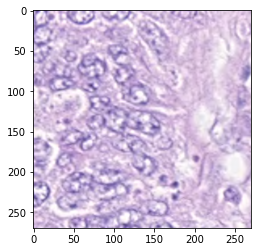

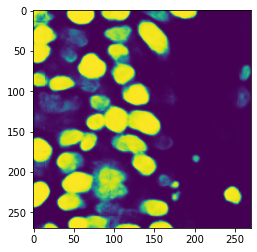

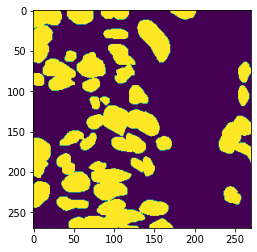

In [8]:
import math
plt.imshow(patch_img_accum[100])
plt.figure()
plt.imshow(patch_pred_accum[100])
plt.figure()
plt.imshow(patch_gt_accum[100])

In [12]:
# patch_img_accum,patch_pred_accum,patch_gt_accum

In [9]:
masks = patch_gt_accum
regions = patch_pred_accum
# num_components = get_data(cache_path)
masks[masks > 1] = 1

In [10]:
def loss_perpolyp_01(T, risk_mass, masks): # lambda in [-1,0]
    # Get the missed pixels 
    num_polyps = masks.max(dim=1)[0].max(dim=1)[0]
    missed = ((masks>0).to(int) - T.to(int)) # as lambda grows, the sets grow.
    F.relu(missed, inplace=True) 
    # Split the different polyps into different rows.
    missed = missed * masks
    results_perpolyp = torch.zeros((num_polyps.sum().int().item(), \
                                    masks.shape[1], masks.shape[2]))
    masks_perpolyp = torch.zeros_like(results_perpolyp)
    k = 0
    for n in range(num_polyps.max().int().item()):
        filter_bool = (num_polyps >= n + 1) # 1, 2, 3 polyps 
        temp_missed = missed[filter_bool]
        temp_masks = masks[filter_bool]
        results_perpolyp[k:k+temp_missed.shape[0]] = (temp_missed == n + 1)
        masks_perpolyp[k:k+temp_missed.shape[0]] = (temp_masks == n+1)
        k += temp_missed.shape[0] 
    results_perpolyp = results_perpolyp.to(float).sum(dim=1).sum(dim=1)/masks_perpolyp.sum(dim=1).sum(dim=1)    
    return results_perpolyp

In [11]:
def get_example_loss_and_size_tables(regions, masks, lambdas_example_table, num_calib):
    lam_len = len(lambdas_example_table)
    lam_low = min(lambdas_example_table)
    lam_high = max(lambdas_example_table)
    fname_loss = f'.cache/{lam_low}_{lam_high}_{lam_len}_example_loss_table.npy'
    fname_sizes = f'.cache/{lam_low}_{lam_high}_{lam_len}_example_size_table.npy'
    try:
        loss_table = np.load(fname_loss)
        sizes_table = np.load(fname_sizes)
    except:
        print("computing loss and size table")
        loss_table = np.zeros((regions.shape[0], lam_len))
        sizes_table = np.zeros((regions.shape[0], lam_len))
        for j in tqdm.tqdm(range(lam_len)):
            est_regions = (regions >= -lambdas_example_table[j])
            print(type(est_regions),est_regions.shape,masks.shape)
            loss_table[:,j] = loss_perpolyp_01(est_regions, regions, masks) 
            sizes_table[:,j] = est_regions.sum(dim=1).sum(dim=1)/masks.sum(dim=1).sum(dim=1)

        np.save(fname_loss, loss_table)
        np.save(fname_sizes, sizes_table)


    return loss_table, sizes_table
# example_loss_table, example_sizes_table = get_example_loss_and_size_tables(regions, masks, \
#                                                                                    lambdas_example_table, \
#                                                                                    num_calib)

In [12]:
def trial_precomputed(example_loss_table, example_size_table, alpha, num_calib, num_lam, lambdas_example_table):
    total=example_loss_table.shape[0]
    perm = torch.randperm(example_loss_table.shape[0])
    example_loss_table = example_loss_table[perm]
    example_size_table = example_size_table[perm]
    calib_losses, val_losses = (example_loss_table[0:num_calib], example_loss_table[num_calib:])
    calib_sizes, val_sizes = (example_size_table[0:num_calib], example_size_table[num_calib:])

    lhat = get_lhat(calib_losses[:,::-1], lambdas_example_table[::-1], alpha)

    losses = val_losses[:,np.argmax(lambdas_example_table == lhat)]
    #print(lhat,losses)
    size = np.random.choice(val_sizes[:,np.argmax(lambdas_example_table == lhat)])

    return lhat, losses.mean(), size

In [13]:
def get_lhat(calib_loss_table, lambdas, alpha, B=1):
    n = calib_loss_table.shape[0]
    rhat = calib_loss_table.mean(axis=0)
#     print()
    lhat_idx = max(np.argmax(((n/(n+1)) * rhat + B/(n+1)) >= alpha) - 1, 0) # Can't be -1.
    #print(lhat_idx, lambdas[lhat_idx])
    return lambdas[lhat_idx]


In [14]:
def experiment(masks, regions, alpha, num_trials, num_calib, num_lam, output_dir, lambdas_example_table):
#     img_names, sigmoids, masks, regions, num_components = get_data(cache_path)
    masks[masks > 1] = 1
    fname = cache_path + f'{alpha}_{num_calib}_{num_lam}_dataframe'.replace('.','_') + '.pkl'

    df = pd.DataFrame(columns=['$\\hat{\\lambda}$','risk','sizes','alpha'])
    try:
        print('Dataframe loaded')
        df = pd.read_pickle(fname)
    except:
        example_loss_table, example_sizes_table = get_example_loss_and_size_tables(regions, masks, \
                                                                                   lambdas_example_table, \
                                                                                   num_calib)

        local_df_list = []
        for i in tqdm.tqdm(range(num_trials)):
            lhat, risk, sizes = trial_precomputed(example_loss_table, example_sizes_table, alpha, num_calib, num_lam, lambdas_example_table)
                
            dict_local = {"$\\hat{\\lambda}$": lhat, "risk": risk, "sizes": sizes, "alpha": alpha}
            df_local = pd.DataFrame(dict_local, index=[i])
            local_df_list = local_df_list + [df_local]
        df = pd.concat(local_df_list, axis=0, ignore_index=True)
        df.to_pickle(fname)

    return df

In [15]:
def plot_histograms(df, alpha, output_dir):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
    axs[0].hist(df['risk'].to_numpy(), alpha=0.7, density=True)

    normalized_size = df['sizes'].to_numpy()
    axs[1].hist(normalized_size, bins=60, alpha=0.7, density=True)

    axs[0].set_xlabel('risk')
    axs[0].locator_params(axis='x', nbins=10)
    axs[0].axvline(x=alpha,c='#999999',linestyle='--',alpha=0.7)
    axs[0].set_ylabel('density')
    axs[1].set_xlabel('set size as a fraction of polyp size')
    axs[1].locator_params(axis='x', nbins=10)
    axs[1].set_yscale('log')
    #axs[1].legend()
    sns.despine(top=True, right=True, ax=axs[0])
    sns.despine(top=True, right=True, ax=axs[1])
    plt.tight_layout()
    plt.savefig( output_dir + (f'{alpha}_polyp_histograms').replace('.','_') + '.pdf'  )
    print(f"The mean and standard deviation of the risk over {len(df)} trials are {df['risk'].mean()} and {df['risk'].std()} respectively.")

In [18]:
# !rm -r './.cache'
# plot_histograms(df, alpha, output_dir)
# len(patch_gt_accum)

1663

Dataframe loaded
computing loss and size table


  0%|                                                 | 0/1000 [00:00<?, ?it/s]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  0%|                                         | 1/1000 [00:02<48:54,  2.94s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  0%|                                         | 2/1000 [00:05<47:19,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  0%|                                         | 3/1000 [00:08<46:48,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  0%|▏                                        | 4/1000 [00:11<46:32,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  0%|▏                                        | 5/1000 [00:14<46:21,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  1%|▏                                        | 6/1000 [00:16<46:12,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  1%|▎                                        | 7/1000 [00:19<46:08,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  1%|▎                                        | 8/1000 [00:22<46:02,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  1%|▎                                        | 9/1000 [00:25<45:56,  2.78s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  1%|▍                                       | 10/1000 [00:27<45:55,  2.78s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  1%|▍                                       | 11/1000 [00:30<45:53,  2.78s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  1%|▍                                       | 12/1000 [00:33<45:59,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  1%|▌                                       | 13/1000 [00:36<45:56,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  1%|▌                                       | 14/1000 [00:39<45:58,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  2%|▌                                       | 15/1000 [00:41<45:52,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  2%|▋                                       | 16/1000 [00:44<46:15,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  2%|▋                                       | 17/1000 [00:47<46:58,  2.87s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  2%|▋                                       | 18/1000 [00:50<47:28,  2.90s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  2%|▊                                       | 19/1000 [00:53<46:58,  2.87s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  2%|▊                                       | 20/1000 [00:56<46:37,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  2%|▊                                       | 21/1000 [00:59<46:21,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  2%|▉                                       | 22/1000 [01:02<46:06,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  2%|▉                                       | 23/1000 [01:04<46:02,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  2%|▉                                       | 24/1000 [01:07<45:54,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  2%|█                                       | 25/1000 [01:10<45:38,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  3%|█                                       | 26/1000 [01:13<45:26,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  3%|█                                       | 27/1000 [01:15<45:16,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  3%|█                                       | 28/1000 [01:18<45:08,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  3%|█▏                                      | 29/1000 [01:21<45:07,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  3%|█▏                                      | 30/1000 [01:24<44:59,  2.78s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  3%|█▏                                      | 31/1000 [01:27<44:54,  2.78s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  3%|█▎                                      | 32/1000 [01:29<44:53,  2.78s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  3%|█▎                                      | 33/1000 [01:32<44:48,  2.78s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  3%|█▎                                      | 34/1000 [01:35<44:47,  2.78s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  4%|█▍                                      | 35/1000 [01:38<44:50,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  4%|█▍                                      | 36/1000 [01:41<44:55,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  4%|█▍                                      | 37/1000 [01:43<44:54,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  4%|█▌                                      | 38/1000 [01:46<44:54,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  4%|█▌                                      | 39/1000 [01:49<44:50,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  4%|█▌                                      | 40/1000 [01:52<44:48,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  4%|█▋                                      | 41/1000 [01:55<44:43,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  4%|█▋                                      | 42/1000 [01:57<44:36,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  4%|█▋                                      | 43/1000 [02:00<44:33,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  4%|█▊                                      | 44/1000 [02:03<44:33,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  4%|█▊                                      | 45/1000 [02:06<44:27,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  5%|█▊                                      | 46/1000 [02:09<44:24,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  5%|█▉                                      | 47/1000 [02:11<44:22,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  5%|█▉                                      | 48/1000 [02:14<44:24,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  5%|█▉                                      | 49/1000 [02:17<44:24,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  5%|██                                      | 50/1000 [02:20<44:20,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  5%|██                                      | 51/1000 [02:23<44:13,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  5%|██                                      | 52/1000 [02:25<44:08,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  5%|██                                      | 53/1000 [02:28<44:09,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  5%|██▏                                     | 54/1000 [02:31<44:05,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  6%|██▏                                     | 55/1000 [02:34<44:00,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  6%|██▏                                     | 56/1000 [02:36<43:56,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  6%|██▎                                     | 57/1000 [02:39<43:55,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  6%|██▎                                     | 58/1000 [02:42<43:53,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  6%|██▎                                     | 59/1000 [02:45<43:46,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  6%|██▍                                     | 60/1000 [02:48<43:44,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  6%|██▍                                     | 61/1000 [02:50<43:47,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  6%|██▍                                     | 62/1000 [02:53<43:44,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  6%|██▌                                     | 63/1000 [02:56<43:36,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  6%|██▌                                     | 64/1000 [02:59<43:30,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  6%|██▌                                     | 65/1000 [03:02<43:32,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  7%|██▋                                     | 66/1000 [03:04<43:41,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  7%|██▋                                     | 67/1000 [03:07<43:39,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  7%|██▋                                     | 68/1000 [03:10<43:33,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  7%|██▊                                     | 69/1000 [03:13<43:26,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  7%|██▊                                     | 70/1000 [03:16<43:26,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  7%|██▊                                     | 71/1000 [03:18<43:22,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  7%|██▉                                     | 72/1000 [03:21<43:20,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  7%|██▉                                     | 73/1000 [03:24<43:10,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  7%|██▉                                     | 74/1000 [03:27<43:07,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  8%|███                                     | 75/1000 [03:30<43:02,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  8%|███                                     | 76/1000 [03:32<42:59,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  8%|███                                     | 77/1000 [03:35<43:00,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  8%|███                                     | 78/1000 [03:38<43:00,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  8%|███▏                                    | 79/1000 [03:41<42:57,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  8%|███▏                                    | 80/1000 [03:44<43:01,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  8%|███▏                                    | 81/1000 [03:46<42:58,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  8%|███▎                                    | 82/1000 [03:49<42:55,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  8%|███▎                                    | 83/1000 [03:52<42:46,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  8%|███▎                                    | 84/1000 [03:55<42:37,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  8%|███▍                                    | 85/1000 [03:58<42:35,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  9%|███▍                                    | 86/1000 [04:00<42:40,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  9%|███▍                                    | 87/1000 [04:03<42:37,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  9%|███▌                                    | 88/1000 [04:06<42:32,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  9%|███▌                                    | 89/1000 [04:09<42:25,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  9%|███▌                                    | 90/1000 [04:12<42:15,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  9%|███▋                                    | 91/1000 [04:14<42:11,  2.78s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  9%|███▋                                    | 92/1000 [04:17<42:09,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  9%|███▋                                    | 93/1000 [04:20<42:11,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


  9%|███▊                                    | 94/1000 [04:23<42:11,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 10%|███▊                                    | 95/1000 [04:26<42:06,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 10%|███▊                                    | 96/1000 [04:28<42:05,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 10%|███▉                                    | 97/1000 [04:31<41:56,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 10%|███▉                                    | 98/1000 [04:34<41:56,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 10%|███▉                                    | 99/1000 [04:37<41:55,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 10%|███▉                                   | 100/1000 [04:40<41:54,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 10%|███▉                                   | 101/1000 [04:42<41:50,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 10%|███▉                                   | 102/1000 [04:45<41:47,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 10%|████                                   | 103/1000 [04:48<41:45,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 10%|████                                   | 104/1000 [04:51<41:50,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 10%|████                                   | 105/1000 [04:54<41:51,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 11%|████▏                                  | 106/1000 [04:56<41:46,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 11%|████▏                                  | 107/1000 [04:59<41:41,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 11%|████▏                                  | 108/1000 [05:02<41:44,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 11%|████▎                                  | 109/1000 [05:05<41:50,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 11%|████▎                                  | 110/1000 [05:08<41:50,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 11%|████▎                                  | 111/1000 [05:10<41:51,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 11%|████▎                                  | 112/1000 [05:13<41:42,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 11%|████▍                                  | 113/1000 [05:16<41:38,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 11%|████▍                                  | 114/1000 [05:19<41:36,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 12%|████▍                                  | 115/1000 [05:22<41:31,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 12%|████▌                                  | 116/1000 [05:24<41:25,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 12%|████▌                                  | 117/1000 [05:27<41:15,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 12%|████▌                                  | 118/1000 [05:30<41:07,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 12%|████▋                                  | 119/1000 [05:33<41:00,  2.79s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 12%|████▋                                  | 120/1000 [05:36<41:02,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 12%|████▋                                  | 121/1000 [05:38<41:01,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 12%|████▊                                  | 122/1000 [05:41<41:02,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 12%|████▊                                  | 123/1000 [05:44<40:59,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 12%|████▊                                  | 124/1000 [05:47<40:53,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 12%|████▉                                  | 125/1000 [05:50<40:48,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 13%|████▉                                  | 126/1000 [05:52<40:48,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 13%|████▉                                  | 127/1000 [05:55<40:46,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 13%|████▉                                  | 128/1000 [05:58<40:42,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 13%|█████                                  | 129/1000 [06:01<40:36,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 13%|█████                                  | 130/1000 [06:04<40:39,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 13%|█████                                  | 131/1000 [06:06<40:39,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 13%|█████▏                                 | 132/1000 [06:09<40:37,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 13%|█████▏                                 | 133/1000 [06:12<40:31,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 13%|█████▏                                 | 134/1000 [06:15<40:31,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 14%|█████▎                                 | 135/1000 [06:18<40:27,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 14%|█████▎                                 | 136/1000 [06:21<40:23,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 14%|█████▎                                 | 137/1000 [06:23<40:16,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 14%|█████▍                                 | 138/1000 [06:26<40:18,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 14%|█████▍                                 | 139/1000 [06:29<40:19,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 14%|█████▍                                 | 140/1000 [06:32<40:13,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 14%|█████▍                                 | 141/1000 [06:35<40:06,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 14%|█████▌                                 | 142/1000 [06:37<40:00,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 14%|█████▌                                 | 143/1000 [06:40<40:03,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 14%|█████▌                                 | 144/1000 [06:43<40:17,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 14%|█████▋                                 | 145/1000 [06:46<40:32,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 15%|█████▋                                 | 146/1000 [06:49<40:48,  2.87s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 15%|█████▋                                 | 147/1000 [06:52<41:09,  2.90s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 15%|█████▊                                 | 148/1000 [06:55<41:17,  2.91s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 15%|█████▊                                 | 149/1000 [06:58<40:54,  2.88s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 15%|█████▊                                 | 150/1000 [07:00<40:38,  2.87s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 15%|█████▉                                 | 151/1000 [07:03<40:26,  2.86s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 15%|█████▉                                 | 152/1000 [07:06<40:53,  2.89s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 15%|█████▉                                 | 153/1000 [07:09<40:55,  2.90s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 15%|██████                                 | 154/1000 [07:12<41:09,  2.92s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 16%|██████                                 | 155/1000 [07:15<41:14,  2.93s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 16%|██████                                 | 156/1000 [07:18<41:29,  2.95s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 16%|██████                                 | 157/1000 [07:21<41:43,  2.97s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 16%|██████▏                                | 158/1000 [07:24<41:09,  2.93s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 16%|██████▏                                | 159/1000 [07:27<40:39,  2.90s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 16%|██████▏                                | 160/1000 [07:30<40:15,  2.88s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 16%|██████▎                                | 161/1000 [07:32<40:03,  2.86s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 16%|██████▎                                | 162/1000 [07:35<39:52,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 16%|██████▎                                | 163/1000 [07:38<39:40,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 16%|██████▍                                | 164/1000 [07:41<39:24,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 16%|██████▍                                | 165/1000 [07:44<39:10,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 17%|██████▍                                | 166/1000 [07:46<39:04,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 17%|██████▌                                | 167/1000 [07:49<38:59,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 17%|██████▌                                | 168/1000 [07:52<38:57,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 17%|██████▌                                | 169/1000 [07:55<38:51,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 17%|██████▋                                | 170/1000 [07:58<38:48,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 17%|██████▋                                | 171/1000 [08:00<38:45,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 17%|██████▋                                | 172/1000 [08:03<38:45,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 17%|██████▋                                | 173/1000 [08:06<38:38,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 17%|██████▊                                | 174/1000 [08:09<38:36,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 18%|██████▊                                | 175/1000 [08:12<38:32,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 18%|██████▊                                | 176/1000 [08:14<38:27,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 18%|██████▉                                | 177/1000 [08:17<38:23,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 18%|██████▉                                | 178/1000 [08:20<38:22,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 18%|██████▉                                | 179/1000 [08:23<38:19,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 18%|███████                                | 180/1000 [08:26<38:16,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 18%|███████                                | 181/1000 [08:28<38:13,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 18%|███████                                | 182/1000 [08:31<38:11,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 18%|███████▏                               | 183/1000 [08:34<38:08,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 18%|███████▏                               | 184/1000 [08:37<38:05,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 18%|███████▏                               | 185/1000 [08:40<38:01,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 19%|███████▎                               | 186/1000 [08:42<37:59,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 19%|███████▎                               | 187/1000 [08:45<37:55,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 19%|███████▎                               | 188/1000 [08:48<37:53,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 19%|███████▎                               | 189/1000 [08:51<37:50,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 19%|███████▍                               | 190/1000 [08:54<37:47,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 19%|███████▍                               | 191/1000 [08:56<37:47,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 19%|███████▍                               | 192/1000 [08:59<37:54,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 19%|███████▌                               | 193/1000 [09:02<37:53,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 19%|███████▌                               | 194/1000 [09:05<37:51,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 20%|███████▌                               | 195/1000 [09:08<37:46,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 20%|███████▋                               | 196/1000 [09:11<37:43,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 20%|███████▋                               | 197/1000 [09:13<37:36,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 20%|███████▋                               | 198/1000 [09:16<37:30,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 20%|███████▊                               | 199/1000 [09:19<37:34,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 20%|███████▊                               | 200/1000 [09:22<37:30,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 20%|███████▊                               | 201/1000 [09:25<37:23,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 20%|███████▉                               | 202/1000 [09:27<37:19,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 20%|███████▉                               | 203/1000 [09:30<37:14,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 20%|███████▉                               | 204/1000 [09:33<37:12,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 20%|███████▉                               | 205/1000 [09:36<37:08,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 21%|████████                               | 206/1000 [09:39<37:21,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 21%|████████                               | 207/1000 [09:41<37:20,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 21%|████████                               | 208/1000 [09:44<37:12,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 21%|████████▏                              | 209/1000 [09:47<37:07,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 21%|████████▏                              | 210/1000 [09:50<37:04,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 21%|████████▏                              | 211/1000 [09:53<36:56,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 21%|████████▎                              | 212/1000 [09:56<36:51,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 21%|████████▎                              | 213/1000 [09:58<36:48,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 21%|████████▎                              | 214/1000 [10:01<36:43,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 22%|████████▍                              | 215/1000 [10:04<36:42,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 22%|████████▍                              | 216/1000 [10:07<36:40,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 22%|████████▍                              | 217/1000 [10:10<36:41,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 22%|████████▌                              | 218/1000 [10:12<36:38,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 22%|████████▌                              | 219/1000 [10:15<36:30,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 22%|████████▌                              | 220/1000 [10:18<36:29,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 22%|████████▌                              | 221/1000 [10:21<36:25,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 22%|████████▋                              | 222/1000 [10:24<36:22,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 22%|████████▋                              | 223/1000 [10:26<36:23,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 22%|████████▋                              | 224/1000 [10:29<36:21,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 22%|████████▊                              | 225/1000 [10:32<36:17,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 23%|████████▊                              | 226/1000 [10:35<36:15,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 23%|████████▊                              | 227/1000 [10:38<36:12,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 23%|████████▉                              | 228/1000 [10:40<36:18,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 23%|████████▉                              | 229/1000 [10:43<36:11,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 23%|████████▉                              | 230/1000 [10:46<36:06,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 23%|█████████                              | 231/1000 [10:49<36:02,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 23%|█████████                              | 232/1000 [10:52<35:59,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 23%|█████████                              | 233/1000 [10:55<35:52,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 23%|█████████▏                             | 234/1000 [10:57<35:48,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 24%|█████████▏                             | 235/1000 [11:00<35:43,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 24%|█████████▏                             | 236/1000 [11:03<35:42,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 24%|█████████▏                             | 237/1000 [11:06<35:40,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 24%|█████████▎                             | 238/1000 [11:09<35:42,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 24%|█████████▎                             | 239/1000 [11:11<35:33,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 24%|█████████▎                             | 240/1000 [11:14<35:30,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 24%|█████████▍                             | 241/1000 [11:17<35:26,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 24%|█████████▍                             | 242/1000 [11:20<35:26,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 24%|█████████▍                             | 243/1000 [11:23<35:27,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 24%|█████████▌                             | 244/1000 [11:25<35:22,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 24%|█████████▌                             | 245/1000 [11:28<35:17,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 25%|█████████▌                             | 246/1000 [11:31<35:12,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 25%|█████████▋                             | 247/1000 [11:34<35:10,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 25%|█████████▋                             | 248/1000 [11:37<35:10,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 25%|█████████▋                             | 249/1000 [11:39<35:09,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 25%|█████████▊                             | 250/1000 [11:42<35:06,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 25%|█████████▊                             | 251/1000 [11:45<35:02,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 25%|█████████▊                             | 252/1000 [11:48<34:58,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 25%|█████████▊                             | 253/1000 [11:51<34:57,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 25%|█████████▉                             | 254/1000 [11:53<34:54,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 26%|█████████▉                             | 255/1000 [11:56<34:50,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 26%|█████████▉                             | 256/1000 [11:59<34:48,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 26%|██████████                             | 257/1000 [12:02<34:42,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 26%|██████████                             | 258/1000 [12:05<34:42,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 26%|██████████                             | 259/1000 [12:08<36:27,  2.95s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 26%|██████████▏                            | 260/1000 [12:11<36:05,  2.93s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 26%|██████████▏                            | 261/1000 [12:14<35:40,  2.90s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 26%|██████████▏                            | 262/1000 [12:16<35:22,  2.88s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 26%|██████████▎                            | 263/1000 [12:19<35:15,  2.87s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 26%|██████████▎                            | 264/1000 [12:22<35:13,  2.87s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 26%|██████████▎                            | 265/1000 [12:25<35:01,  2.86s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 27%|██████████▎                            | 266/1000 [12:28<34:49,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 27%|██████████▍                            | 267/1000 [12:31<34:40,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 27%|██████████▍                            | 268/1000 [12:34<34:36,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 27%|██████████▍                            | 269/1000 [12:36<34:30,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 27%|██████████▌                            | 270/1000 [12:39<34:23,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 27%|██████████▌                            | 271/1000 [12:42<34:16,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 27%|██████████▌                            | 272/1000 [12:45<34:12,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 27%|██████████▋                            | 273/1000 [12:48<34:06,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 27%|██████████▋                            | 274/1000 [12:50<34:03,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 28%|██████████▋                            | 275/1000 [12:53<33:55,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 28%|██████████▊                            | 276/1000 [12:56<33:51,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 28%|██████████▊                            | 277/1000 [12:59<33:51,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 28%|██████████▊                            | 278/1000 [13:02<33:54,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 28%|██████████▉                            | 279/1000 [13:04<33:50,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 28%|██████████▉                            | 280/1000 [13:07<33:47,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 28%|██████████▉                            | 281/1000 [13:10<33:47,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 28%|██████████▉                            | 282/1000 [13:13<33:43,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 28%|███████████                            | 283/1000 [13:16<33:41,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 28%|███████████                            | 284/1000 [13:19<33:41,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 28%|███████████                            | 285/1000 [13:21<33:59,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 29%|███████████▏                           | 286/1000 [13:25<35:01,  2.94s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 29%|███████████▏                           | 287/1000 [13:28<35:04,  2.95s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 29%|███████████▏                           | 288/1000 [13:30<34:40,  2.92s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 29%|███████████▎                           | 289/1000 [13:33<34:19,  2.90s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 29%|███████████▎                           | 290/1000 [13:36<34:01,  2.88s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 29%|███████████▎                           | 291/1000 [13:39<33:48,  2.86s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 29%|███████████▍                           | 292/1000 [13:42<33:34,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 29%|███████████▍                           | 293/1000 [13:45<33:25,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 29%|███████████▍                           | 294/1000 [13:47<33:17,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 30%|███████████▌                           | 295/1000 [13:50<33:14,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 30%|███████████▌                           | 296/1000 [13:53<33:07,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 30%|███████████▌                           | 297/1000 [13:56<33:03,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 30%|███████████▌                           | 298/1000 [13:59<33:00,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 30%|███████████▋                           | 299/1000 [14:01<32:57,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 30%|███████████▋                           | 300/1000 [14:04<32:59,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 30%|███████████▋                           | 301/1000 [14:07<33:04,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 30%|███████████▊                           | 302/1000 [14:10<33:12,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 30%|███████████▊                           | 303/1000 [14:13<33:03,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 30%|███████████▊                           | 304/1000 [14:16<32:57,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 30%|███████████▉                           | 305/1000 [14:19<32:54,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 31%|███████████▉                           | 306/1000 [14:21<32:46,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 31%|███████████▉                           | 307/1000 [14:24<32:38,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 31%|████████████                           | 308/1000 [14:27<32:34,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 31%|████████████                           | 309/1000 [14:30<32:32,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 31%|████████████                           | 310/1000 [14:33<32:29,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 31%|████████████▏                          | 311/1000 [14:35<32:23,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 31%|████████████▏                          | 312/1000 [14:38<32:21,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 31%|████████████▏                          | 313/1000 [14:41<32:14,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 31%|████████████▏                          | 314/1000 [14:44<32:07,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 32%|████████████▎                          | 315/1000 [14:47<32:04,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 32%|████████████▎                          | 316/1000 [14:50<32:01,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 32%|████████████▎                          | 317/1000 [14:52<31:55,  2.80s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 32%|████████████▍                          | 318/1000 [14:55<32:02,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 32%|████████████▍                          | 319/1000 [14:58<32:01,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 32%|████████████▍                          | 320/1000 [15:01<31:59,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 32%|████████████▌                          | 321/1000 [15:04<31:56,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 32%|████████████▌                          | 322/1000 [15:06<31:53,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 32%|████████████▌                          | 323/1000 [15:09<31:50,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 32%|████████████▋                          | 324/1000 [15:12<31:54,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 32%|████████████▋                          | 325/1000 [15:15<31:53,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 33%|████████████▋                          | 326/1000 [15:18<31:51,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 33%|████████████▊                          | 327/1000 [15:21<31:49,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 33%|████████████▊                          | 328/1000 [15:23<31:43,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 33%|████████████▊                          | 329/1000 [15:26<31:35,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 33%|████████████▊                          | 330/1000 [15:29<31:27,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 33%|████████████▉                          | 331/1000 [15:32<31:21,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 33%|████████████▉                          | 332/1000 [15:35<31:23,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 33%|████████████▉                          | 333/1000 [15:38<31:18,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 33%|█████████████                          | 334/1000 [15:40<31:16,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 34%|█████████████                          | 335/1000 [15:43<31:11,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 34%|█████████████                          | 336/1000 [15:46<31:08,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 34%|█████████████▏                         | 337/1000 [15:49<31:07,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 34%|█████████████▏                         | 338/1000 [15:52<31:04,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 34%|█████████████▏                         | 339/1000 [15:54<31:03,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 34%|█████████████▎                         | 340/1000 [15:57<31:00,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 34%|█████████████▎                         | 341/1000 [16:00<30:51,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 34%|█████████████▎                         | 342/1000 [16:03<30:48,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 34%|█████████████▍                         | 343/1000 [16:06<30:46,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 34%|█████████████▍                         | 344/1000 [16:08<30:47,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 34%|█████████████▍                         | 345/1000 [16:11<30:48,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 35%|█████████████▍                         | 346/1000 [16:14<30:48,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 35%|█████████████▌                         | 347/1000 [16:17<30:46,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 35%|█████████████▌                         | 348/1000 [16:20<30:46,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 35%|█████████████▌                         | 349/1000 [16:23<30:45,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 35%|█████████████▋                         | 350/1000 [16:26<30:41,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 35%|█████████████▋                         | 351/1000 [16:28<30:33,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 35%|█████████████▋                         | 352/1000 [16:31<30:25,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 35%|█████████████▊                         | 353/1000 [16:34<30:20,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 35%|█████████████▊                         | 354/1000 [16:37<30:14,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 36%|█████████████▊                         | 355/1000 [16:40<30:10,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 36%|█████████████▉                         | 356/1000 [16:42<30:10,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 36%|█████████████▉                         | 357/1000 [16:45<30:06,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 36%|█████████████▉                         | 358/1000 [16:48<30:06,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 36%|██████████████                         | 359/1000 [16:51<30:06,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 36%|██████████████                         | 360/1000 [16:54<30:13,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 36%|██████████████                         | 361/1000 [16:57<30:09,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 36%|██████████████                         | 362/1000 [16:59<30:03,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 36%|██████████████▏                        | 363/1000 [17:02<29:57,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 36%|██████████████▏                        | 364/1000 [17:05<29:53,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 36%|██████████████▏                        | 365/1000 [17:08<29:49,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 37%|██████████████▎                        | 366/1000 [17:11<29:44,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 37%|██████████████▎                        | 367/1000 [17:13<29:43,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 37%|██████████████▎                        | 368/1000 [17:16<29:46,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 37%|██████████████▍                        | 369/1000 [17:19<29:42,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 37%|██████████████▍                        | 370/1000 [17:22<29:41,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 37%|██████████████▍                        | 371/1000 [17:25<29:33,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 37%|██████████████▌                        | 372/1000 [17:28<29:34,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 37%|██████████████▌                        | 373/1000 [17:30<29:31,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 37%|██████████████▌                        | 374/1000 [17:33<29:31,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 38%|██████████████▋                        | 375/1000 [17:36<29:27,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 38%|██████████████▋                        | 376/1000 [17:39<29:26,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 38%|██████████████▋                        | 377/1000 [17:42<29:19,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 38%|██████████████▋                        | 378/1000 [17:44<29:15,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 38%|██████████████▊                        | 379/1000 [17:47<29:10,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 38%|██████████████▊                        | 380/1000 [17:50<29:10,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 38%|██████████████▊                        | 381/1000 [17:53<29:06,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 38%|██████████████▉                        | 382/1000 [17:56<29:01,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 38%|██████████████▉                        | 383/1000 [17:59<28:56,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 38%|██████████████▉                        | 384/1000 [18:01<28:54,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 38%|███████████████                        | 385/1000 [18:04<28:58,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 39%|███████████████                        | 386/1000 [18:07<28:56,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 39%|███████████████                        | 387/1000 [18:10<28:51,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 39%|███████████████▏                       | 388/1000 [18:13<28:49,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 39%|███████████████▏                       | 389/1000 [18:16<28:45,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 39%|███████████████▏                       | 390/1000 [18:18<28:43,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 39%|███████████████▏                       | 391/1000 [18:21<28:42,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 39%|███████████████▎                       | 392/1000 [18:24<28:37,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 39%|███████████████▎                       | 393/1000 [18:27<28:34,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 39%|███████████████▎                       | 394/1000 [18:30<28:30,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 40%|███████████████▍                       | 395/1000 [18:32<28:28,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 40%|███████████████▍                       | 396/1000 [18:35<28:28,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 40%|███████████████▍                       | 397/1000 [18:38<28:39,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 40%|███████████████▌                       | 398/1000 [18:41<28:32,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 40%|███████████████▌                       | 399/1000 [18:44<28:28,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 40%|███████████████▌                       | 400/1000 [18:47<28:25,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 40%|███████████████▋                       | 401/1000 [18:50<28:20,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 40%|███████████████▋                       | 402/1000 [18:52<28:12,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 40%|███████████████▋                       | 403/1000 [18:55<28:07,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 40%|███████████████▊                       | 404/1000 [18:58<28:02,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 40%|███████████████▊                       | 405/1000 [19:01<28:04,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 41%|███████████████▊                       | 406/1000 [19:04<28:00,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 41%|███████████████▊                       | 407/1000 [19:07<27:58,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 41%|███████████████▉                       | 408/1000 [19:09<27:51,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 41%|███████████████▉                       | 409/1000 [19:12<27:46,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 41%|███████████████▉                       | 410/1000 [19:15<27:43,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 41%|████████████████                       | 411/1000 [19:18<27:39,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 41%|████████████████                       | 412/1000 [19:21<27:38,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 41%|████████████████                       | 413/1000 [19:23<27:35,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 41%|████████████████▏                      | 414/1000 [19:26<27:29,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 42%|████████████████▏                      | 415/1000 [19:29<27:52,  2.86s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 42%|████████████████▏                      | 416/1000 [19:32<27:48,  2.86s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 42%|████████████████▎                      | 417/1000 [19:35<27:42,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 42%|████████████████▎                      | 418/1000 [19:38<27:57,  2.88s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 42%|████████████████▎                      | 419/1000 [19:41<28:54,  2.98s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 42%|████████████████▍                      | 420/1000 [19:44<28:50,  2.98s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 42%|████████████████▍                      | 421/1000 [19:47<28:20,  2.94s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 42%|████████████████▍                      | 422/1000 [19:50<28:03,  2.91s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 42%|████████████████▍                      | 423/1000 [19:53<27:46,  2.89s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 42%|████████████████▌                      | 424/1000 [19:55<27:33,  2.87s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 42%|████████████████▌                      | 425/1000 [19:58<27:23,  2.86s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 43%|████████████████▌                      | 426/1000 [20:01<27:15,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 43%|████████████████▋                      | 427/1000 [20:04<27:10,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 43%|████████████████▋                      | 428/1000 [20:07<27:02,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 43%|████████████████▋                      | 429/1000 [20:09<26:55,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 43%|████████████████▊                      | 430/1000 [20:12<26:50,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 43%|████████████████▊                      | 431/1000 [20:15<26:51,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 43%|████████████████▊                      | 432/1000 [20:18<26:49,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 43%|████████████████▉                      | 433/1000 [20:21<26:46,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 43%|████████████████▉                      | 434/1000 [20:24<26:44,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 44%|████████████████▉                      | 435/1000 [20:27<26:51,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 44%|█████████████████                      | 436/1000 [20:29<26:47,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 44%|█████████████████                      | 437/1000 [20:32<26:40,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 44%|█████████████████                      | 438/1000 [20:35<26:37,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 44%|█████████████████                      | 439/1000 [20:38<26:31,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 44%|█████████████████▏                     | 440/1000 [20:41<26:30,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 44%|█████████████████▏                     | 441/1000 [20:44<26:26,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 44%|█████████████████▏                     | 442/1000 [20:46<26:23,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 44%|█████████████████▎                     | 443/1000 [20:49<26:21,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 44%|█████████████████▎                     | 444/1000 [20:52<26:19,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 44%|█████████████████▎                     | 445/1000 [20:55<26:14,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 45%|█████████████████▍                     | 446/1000 [20:58<26:10,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 45%|█████████████████▍                     | 447/1000 [21:01<26:19,  2.86s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 45%|█████████████████▍                     | 448/1000 [21:04<26:13,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 45%|█████████████████▌                     | 449/1000 [21:06<26:10,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 45%|█████████████████▌                     | 450/1000 [21:09<26:03,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 45%|█████████████████▌                     | 451/1000 [21:12<26:01,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 45%|█████████████████▋                     | 452/1000 [21:15<25:54,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 45%|█████████████████▋                     | 453/1000 [21:18<25:51,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 45%|█████████████████▋                     | 454/1000 [21:21<25:47,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 46%|█████████████████▋                     | 455/1000 [21:23<25:46,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 46%|█████████████████▊                     | 456/1000 [21:26<25:42,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 46%|█████████████████▊                     | 457/1000 [21:29<25:37,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 46%|█████████████████▊                     | 458/1000 [21:32<25:38,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 46%|█████████████████▉                     | 459/1000 [21:35<25:38,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 46%|█████████████████▉                     | 460/1000 [21:38<25:31,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 46%|█████████████████▉                     | 461/1000 [21:40<25:32,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 46%|██████████████████                     | 462/1000 [21:43<25:29,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 46%|██████████████████                     | 463/1000 [21:46<25:39,  2.87s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 46%|██████████████████                     | 464/1000 [21:49<25:41,  2.88s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 46%|██████████████████▏                    | 465/1000 [21:52<25:31,  2.86s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 47%|██████████████████▏                    | 466/1000 [21:55<25:22,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 47%|██████████████████▏                    | 467/1000 [21:58<25:18,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 47%|██████████████████▎                    | 468/1000 [22:00<25:12,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 47%|██████████████████▎                    | 469/1000 [22:03<25:09,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 47%|██████████████████▎                    | 470/1000 [22:06<25:06,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 47%|██████████████████▎                    | 471/1000 [22:09<25:03,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 47%|██████████████████▍                    | 472/1000 [22:12<24:59,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 47%|██████████████████▍                    | 473/1000 [22:15<24:53,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 47%|██████████████████▍                    | 474/1000 [22:17<24:49,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 48%|██████████████████▌                    | 475/1000 [22:20<24:46,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 48%|██████████████████▌                    | 476/1000 [22:23<24:42,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 48%|██████████████████▌                    | 477/1000 [22:26<24:36,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 48%|██████████████████▋                    | 478/1000 [22:29<24:33,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 48%|██████████████████▋                    | 479/1000 [22:32<25:01,  2.88s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 48%|██████████████████▋                    | 480/1000 [22:35<24:54,  2.87s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 48%|██████████████████▊                    | 481/1000 [22:37<24:44,  2.86s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 48%|██████████████████▊                    | 482/1000 [22:40<24:36,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 48%|██████████████████▊                    | 483/1000 [22:43<24:31,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 48%|██████████████████▉                    | 484/1000 [22:46<24:40,  2.87s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 48%|██████████████████▉                    | 485/1000 [22:49<24:33,  2.86s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 49%|██████████████████▉                    | 486/1000 [22:52<24:27,  2.86s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 49%|██████████████████▉                    | 487/1000 [22:54<24:20,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 49%|███████████████████                    | 488/1000 [22:57<24:16,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 49%|███████████████████                    | 489/1000 [23:00<24:11,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 49%|███████████████████                    | 490/1000 [23:03<24:11,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 49%|███████████████████▏                   | 491/1000 [23:06<24:07,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 49%|███████████████████▏                   | 492/1000 [23:09<24:07,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 49%|███████████████████▏                   | 493/1000 [23:12<24:01,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 49%|███████████████████▎                   | 494/1000 [23:14<23:56,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 50%|███████████████████▎                   | 495/1000 [23:17<23:51,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 50%|███████████████████▎                   | 496/1000 [23:20<23:48,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 50%|███████████████████▍                   | 497/1000 [23:23<23:43,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 50%|███████████████████▍                   | 498/1000 [23:26<23:40,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 50%|███████████████████▍                   | 499/1000 [23:29<23:38,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 50%|███████████████████▌                   | 500/1000 [23:31<23:35,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 50%|███████████████████▌                   | 501/1000 [23:34<23:32,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 50%|███████████████████▌                   | 502/1000 [23:37<23:29,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 50%|███████████████████▌                   | 503/1000 [23:40<23:25,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 50%|███████████████████▋                   | 504/1000 [23:43<23:24,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 50%|███████████████████▋                   | 505/1000 [23:45<23:20,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 51%|███████████████████▋                   | 506/1000 [23:48<23:19,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 51%|███████████████████▊                   | 507/1000 [23:51<23:18,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 51%|███████████████████▊                   | 508/1000 [23:54<23:14,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 51%|███████████████████▊                   | 509/1000 [23:57<23:09,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 51%|███████████████████▉                   | 510/1000 [24:00<23:09,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 51%|███████████████████▉                   | 511/1000 [24:03<23:08,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 51%|███████████████████▉                   | 512/1000 [24:05<23:06,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 51%|████████████████████                   | 513/1000 [24:08<23:01,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 51%|████████████████████                   | 514/1000 [24:11<22:57,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 52%|████████████████████                   | 515/1000 [24:14<22:53,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 52%|████████████████████                   | 516/1000 [24:17<22:53,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 52%|████████████████████▏                  | 517/1000 [24:20<22:48,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 52%|████████████████████▏                  | 518/1000 [24:22<22:45,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 52%|████████████████████▏                  | 519/1000 [24:25<22:40,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 52%|████████████████████▎                  | 520/1000 [24:28<22:36,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 52%|████████████████████▎                  | 521/1000 [24:31<22:33,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 52%|████████████████████▎                  | 522/1000 [24:34<22:29,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 52%|████████████████████▍                  | 523/1000 [24:36<22:27,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 52%|████████████████████▍                  | 524/1000 [24:39<22:24,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 52%|████████████████████▍                  | 525/1000 [24:42<22:21,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 53%|████████████████████▌                  | 526/1000 [24:45<22:19,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 53%|████████████████████▌                  | 527/1000 [24:48<22:21,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 53%|████████████████████▌                  | 528/1000 [24:51<22:21,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 53%|████████████████████▋                  | 529/1000 [24:53<22:13,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 53%|████████████████████▋                  | 530/1000 [24:56<22:13,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 53%|████████████████████▋                  | 531/1000 [24:59<22:07,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 53%|████████████████████▋                  | 532/1000 [25:02<22:03,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 53%|████████████████████▊                  | 533/1000 [25:05<21:59,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 53%|████████████████████▊                  | 534/1000 [25:08<21:54,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 54%|████████████████████▊                  | 535/1000 [25:10<21:52,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 54%|████████████████████▉                  | 536/1000 [25:13<21:48,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 54%|████████████████████▉                  | 537/1000 [25:16<21:46,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 54%|████████████████████▉                  | 538/1000 [25:19<21:45,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 54%|█████████████████████                  | 539/1000 [25:22<21:40,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 54%|█████████████████████                  | 540/1000 [25:25<21:37,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 54%|█████████████████████                  | 541/1000 [25:27<21:37,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 54%|█████████████████████▏                 | 542/1000 [25:30<21:32,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 54%|█████████████████████▏                 | 543/1000 [25:33<21:30,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 54%|█████████████████████▏                 | 544/1000 [25:36<21:28,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 55%|█████████████████████▎                 | 545/1000 [25:39<21:24,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 55%|█████████████████████▎                 | 546/1000 [25:41<21:20,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 55%|█████████████████████▎                 | 547/1000 [25:44<21:18,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 55%|█████████████████████▎                 | 548/1000 [25:47<21:16,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 55%|█████████████████████▍                 | 549/1000 [25:50<21:13,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 55%|█████████████████████▍                 | 550/1000 [25:53<21:12,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 55%|█████████████████████▍                 | 551/1000 [25:56<21:09,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 55%|█████████████████████▌                 | 552/1000 [25:58<21:11,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 55%|█████████████████████▌                 | 553/1000 [26:01<21:08,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 55%|█████████████████████▌                 | 554/1000 [26:04<21:02,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 56%|█████████████████████▋                 | 555/1000 [26:07<20:57,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 56%|█████████████████████▋                 | 556/1000 [26:10<20:56,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 56%|█████████████████████▋                 | 557/1000 [26:13<20:53,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 56%|█████████████████████▊                 | 558/1000 [26:15<20:51,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 56%|█████████████████████▊                 | 559/1000 [26:18<20:46,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 56%|█████████████████████▊                 | 560/1000 [26:21<20:43,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 56%|█████████████████████▉                 | 561/1000 [26:24<20:41,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 56%|█████████████████████▉                 | 562/1000 [26:27<20:35,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 56%|█████████████████████▉                 | 563/1000 [26:30<20:30,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 56%|█████████████████████▉                 | 564/1000 [26:32<20:29,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 56%|██████████████████████                 | 565/1000 [26:35<20:30,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 57%|██████████████████████                 | 566/1000 [26:38<20:27,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 57%|██████████████████████                 | 567/1000 [26:41<20:23,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 57%|██████████████████████▏                | 568/1000 [26:44<20:23,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 57%|██████████████████████▏                | 569/1000 [26:47<20:26,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 57%|██████████████████████▏                | 570/1000 [26:49<20:22,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 57%|██████████████████████▎                | 571/1000 [26:52<20:17,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 57%|██████████████████████▎                | 572/1000 [26:55<20:11,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 57%|██████████████████████▎                | 573/1000 [26:58<20:07,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 57%|██████████████████████▍                | 574/1000 [27:01<20:01,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 57%|██████████████████████▍                | 575/1000 [27:03<20:00,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 58%|██████████████████████▍                | 576/1000 [27:06<19:55,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 58%|██████████████████████▌                | 577/1000 [27:09<19:54,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 58%|██████████████████████▌                | 578/1000 [27:12<19:53,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 58%|██████████████████████▌                | 579/1000 [27:15<19:51,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 58%|██████████████████████▌                | 580/1000 [27:18<19:49,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 58%|██████████████████████▋                | 581/1000 [27:20<19:47,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 58%|██████████████████████▋                | 582/1000 [27:23<19:44,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 58%|██████████████████████▋                | 583/1000 [27:26<19:40,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 58%|██████████████████████▊                | 584/1000 [27:29<19:34,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 58%|██████████████████████▊                | 585/1000 [27:32<19:30,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 59%|██████████████████████▊                | 586/1000 [27:35<19:30,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 59%|██████████████████████▉                | 587/1000 [27:38<19:44,  2.87s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 59%|██████████████████████▉                | 588/1000 [27:40<19:37,  2.86s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 59%|██████████████████████▉                | 589/1000 [27:43<19:30,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 59%|███████████████████████                | 590/1000 [27:46<19:25,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 59%|███████████████████████                | 591/1000 [27:49<19:22,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 59%|███████████████████████                | 592/1000 [27:52<19:17,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 59%|███████████████████████▏               | 593/1000 [27:55<19:14,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 59%|███████████████████████▏               | 594/1000 [27:57<19:14,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 60%|███████████████████████▏               | 595/1000 [28:00<19:10,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 60%|███████████████████████▏               | 596/1000 [28:03<19:06,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 60%|███████████████████████▎               | 597/1000 [28:06<19:04,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 60%|███████████████████████▎               | 598/1000 [28:09<18:58,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 60%|███████████████████████▎               | 599/1000 [28:12<18:56,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 60%|███████████████████████▍               | 600/1000 [28:14<18:49,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 60%|███████████████████████▍               | 601/1000 [28:17<18:45,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 60%|███████████████████████▍               | 602/1000 [28:20<18:43,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 60%|███████████████████████▌               | 603/1000 [28:23<18:42,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 60%|███████████████████████▌               | 604/1000 [28:26<18:38,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 60%|███████████████████████▌               | 605/1000 [28:29<18:35,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 61%|███████████████████████▋               | 606/1000 [28:31<18:31,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 61%|███████████████████████▋               | 607/1000 [28:34<18:32,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 61%|███████████████████████▋               | 608/1000 [28:37<18:30,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 61%|███████████████████████▊               | 609/1000 [28:40<18:25,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 61%|███████████████████████▊               | 610/1000 [28:43<18:23,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 61%|███████████████████████▊               | 611/1000 [28:46<18:24,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 61%|███████████████████████▊               | 612/1000 [28:48<18:24,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 61%|███████████████████████▉               | 613/1000 [28:51<18:21,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 61%|███████████████████████▉               | 614/1000 [28:54<18:17,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 62%|███████████████████████▉               | 615/1000 [28:57<18:15,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 62%|████████████████████████               | 616/1000 [29:00<18:19,  2.86s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 62%|████████████████████████               | 617/1000 [29:03<18:14,  2.86s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 62%|████████████████████████               | 618/1000 [29:06<18:08,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 62%|████████████████████████▏              | 619/1000 [29:08<18:04,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 62%|████████████████████████▏              | 620/1000 [29:11<18:01,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 62%|████████████████████████▏              | 621/1000 [29:14<17:56,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 62%|████████████████████████▎              | 622/1000 [29:17<17:51,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 62%|████████████████████████▎              | 623/1000 [29:20<17:49,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 62%|████████████████████████▎              | 624/1000 [29:23<17:46,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 62%|████████████████████████▍              | 625/1000 [29:25<17:42,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 63%|████████████████████████▍              | 626/1000 [29:28<17:41,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 63%|████████████████████████▍              | 627/1000 [29:31<17:57,  2.89s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 63%|████████████████████████▍              | 628/1000 [29:34<17:50,  2.88s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 63%|████████████████████████▌              | 629/1000 [29:37<17:43,  2.87s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 63%|████████████████████████▌              | 630/1000 [29:40<17:36,  2.86s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 63%|████████████████████████▌              | 631/1000 [29:43<17:31,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 63%|████████████████████████▋              | 632/1000 [29:45<17:25,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 63%|████████████████████████▋              | 633/1000 [29:48<17:25,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 63%|████████████████████████▋              | 634/1000 [29:51<17:23,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 64%|████████████████████████▊              | 635/1000 [29:54<17:16,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 64%|████████████████████████▊              | 636/1000 [29:57<17:11,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 64%|████████████████████████▊              | 637/1000 [30:00<17:07,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 64%|████████████████████████▉              | 638/1000 [30:02<17:04,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 64%|████████████████████████▉              | 639/1000 [30:05<17:02,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 64%|████████████████████████▉              | 640/1000 [30:08<16:58,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 64%|████████████████████████▉              | 641/1000 [30:11<16:52,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 64%|█████████████████████████              | 642/1000 [30:14<16:50,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 64%|█████████████████████████              | 643/1000 [30:16<16:45,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 64%|█████████████████████████              | 644/1000 [30:19<16:43,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 64%|█████████████████████████▏             | 645/1000 [30:22<16:40,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 65%|█████████████████████████▏             | 646/1000 [30:25<16:39,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 65%|█████████████████████████▏             | 647/1000 [30:28<16:37,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 65%|█████████████████████████▎             | 648/1000 [30:31<16:34,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 65%|█████████████████████████▎             | 649/1000 [30:33<16:32,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 65%|█████████████████████████▎             | 650/1000 [30:36<16:30,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 65%|█████████████████████████▍             | 651/1000 [30:39<16:29,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 65%|█████████████████████████▍             | 652/1000 [30:42<16:27,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 65%|█████████████████████████▍             | 653/1000 [30:45<16:23,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 65%|█████████████████████████▌             | 654/1000 [30:48<16:24,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 66%|█████████████████████████▌             | 655/1000 [30:51<16:22,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 66%|█████████████████████████▌             | 656/1000 [30:53<16:17,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 66%|█████████████████████████▌             | 657/1000 [30:56<16:12,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 66%|█████████████████████████▋             | 658/1000 [30:59<16:07,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 66%|█████████████████████████▋             | 659/1000 [31:02<16:02,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 66%|█████████████████████████▋             | 660/1000 [31:05<16:00,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 66%|█████████████████████████▊             | 661/1000 [31:07<15:55,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 66%|█████████████████████████▊             | 662/1000 [31:10<15:53,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 66%|█████████████████████████▊             | 663/1000 [31:13<15:51,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 66%|█████████████████████████▉             | 664/1000 [31:16<15:49,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 66%|█████████████████████████▉             | 665/1000 [31:19<15:47,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 67%|█████████████████████████▉             | 666/1000 [31:22<15:45,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 67%|██████████████████████████             | 667/1000 [31:24<15:43,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 67%|██████████████████████████             | 668/1000 [31:27<15:41,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 67%|██████████████████████████             | 669/1000 [31:30<15:38,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 67%|██████████████████████████▏            | 670/1000 [31:33<15:35,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 67%|██████████████████████████▏            | 671/1000 [31:36<15:31,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 67%|██████████████████████████▏            | 672/1000 [31:39<15:27,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 67%|██████████████████████████▏            | 673/1000 [31:41<15:22,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 67%|██████████████████████████▎            | 674/1000 [31:44<15:18,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 68%|██████████████████████████▎            | 675/1000 [31:47<15:13,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 68%|██████████████████████████▎            | 676/1000 [31:50<15:11,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 68%|██████████████████████████▍            | 677/1000 [31:53<15:09,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 68%|██████████████████████████▍            | 678/1000 [31:55<15:07,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 68%|██████████████████████████▍            | 679/1000 [31:58<15:05,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 68%|██████████████████████████▌            | 680/1000 [32:01<15:02,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 68%|██████████████████████████▌            | 681/1000 [32:04<15:01,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 68%|██████████████████████████▌            | 682/1000 [32:07<14:58,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 68%|██████████████████████████▋            | 683/1000 [32:10<15:07,  2.86s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 68%|██████████████████████████▋            | 684/1000 [32:13<15:00,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 68%|██████████████████████████▋            | 685/1000 [32:15<14:58,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 69%|██████████████████████████▊            | 686/1000 [32:18<14:56,  2.86s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 69%|██████████████████████████▊            | 687/1000 [32:21<14:51,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 69%|██████████████████████████▊            | 688/1000 [32:24<14:47,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 69%|██████████████████████████▊            | 689/1000 [32:27<14:43,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 69%|██████████████████████████▉            | 690/1000 [32:30<14:39,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 69%|██████████████████████████▉            | 691/1000 [32:32<14:34,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 69%|██████████████████████████▉            | 692/1000 [32:35<14:32,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 69%|███████████████████████████            | 693/1000 [32:38<14:29,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 69%|███████████████████████████            | 694/1000 [32:41<14:26,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 70%|███████████████████████████            | 695/1000 [32:44<14:23,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 70%|███████████████████████████▏           | 696/1000 [32:47<14:20,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 70%|███████████████████████████▏           | 697/1000 [32:49<14:17,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 70%|███████████████████████████▏           | 698/1000 [32:52<14:14,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 70%|███████████████████████████▎           | 699/1000 [32:55<14:12,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 70%|███████████████████████████▎           | 700/1000 [32:58<14:09,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 70%|███████████████████████████▎           | 701/1000 [33:01<14:04,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 70%|███████████████████████████▍           | 702/1000 [33:04<14:03,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 70%|███████████████████████████▍           | 703/1000 [33:06<14:01,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 70%|███████████████████████████▍           | 704/1000 [33:09<13:59,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 70%|███████████████████████████▍           | 705/1000 [33:12<13:56,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 71%|███████████████████████████▌           | 706/1000 [33:15<13:53,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 71%|███████████████████████████▌           | 707/1000 [33:18<13:50,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 71%|███████████████████████████▌           | 708/1000 [33:21<13:49,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 71%|███████████████████████████▋           | 709/1000 [33:23<13:45,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 71%|███████████████████████████▋           | 710/1000 [33:26<13:42,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 71%|███████████████████████████▋           | 711/1000 [33:29<13:38,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 71%|███████████████████████████▊           | 712/1000 [33:32<13:34,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 71%|███████████████████████████▊           | 713/1000 [33:35<13:33,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 71%|███████████████████████████▊           | 714/1000 [33:38<13:30,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 72%|███████████████████████████▉           | 715/1000 [33:40<13:26,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 72%|███████████████████████████▉           | 716/1000 [33:43<13:23,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 72%|███████████████████████████▉           | 717/1000 [33:46<13:20,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 72%|████████████████████████████           | 718/1000 [33:49<13:17,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 72%|████████████████████████████           | 719/1000 [33:52<13:13,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 72%|████████████████████████████           | 720/1000 [33:54<13:10,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 72%|████████████████████████████           | 721/1000 [33:57<13:07,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 72%|████████████████████████████▏          | 722/1000 [34:00<13:06,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 72%|████████████████████████████▏          | 723/1000 [34:03<13:03,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 72%|████████████████████████████▏          | 724/1000 [34:06<12:59,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 72%|████████████████████████████▎          | 725/1000 [34:09<12:57,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 73%|████████████████████████████▎          | 726/1000 [34:11<12:55,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 73%|████████████████████████████▎          | 727/1000 [34:14<12:52,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 73%|████████████████████████████▍          | 728/1000 [34:17<12:48,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 73%|████████████████████████████▍          | 729/1000 [34:20<12:46,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 73%|████████████████████████████▍          | 730/1000 [34:23<12:42,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 73%|████████████████████████████▌          | 731/1000 [34:26<12:37,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 73%|████████████████████████████▌          | 732/1000 [34:28<12:33,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 73%|████████████████████████████▌          | 733/1000 [34:31<12:31,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 73%|████████████████████████████▋          | 734/1000 [34:34<12:31,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 74%|████████████████████████████▋          | 735/1000 [34:37<12:28,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 74%|████████████████████████████▋          | 736/1000 [34:40<12:26,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 74%|████████████████████████████▋          | 737/1000 [34:43<12:23,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 74%|████████████████████████████▊          | 738/1000 [34:45<12:20,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 74%|████████████████████████████▊          | 739/1000 [34:48<12:15,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 74%|████████████████████████████▊          | 740/1000 [34:51<12:14,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 74%|████████████████████████████▉          | 741/1000 [34:54<12:12,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 74%|████████████████████████████▉          | 742/1000 [34:57<12:12,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 74%|████████████████████████████▉          | 743/1000 [35:00<12:09,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 74%|█████████████████████████████          | 744/1000 [35:02<12:05,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 74%|█████████████████████████████          | 745/1000 [35:05<12:03,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 75%|█████████████████████████████          | 746/1000 [35:08<11:59,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 75%|█████████████████████████████▏         | 747/1000 [35:11<11:55,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 75%|█████████████████████████████▏         | 748/1000 [35:14<11:51,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 75%|█████████████████████████████▏         | 749/1000 [35:16<11:49,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 75%|█████████████████████████████▎         | 750/1000 [35:19<11:47,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 75%|█████████████████████████████▎         | 751/1000 [35:22<11:44,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 75%|█████████████████████████████▎         | 752/1000 [35:25<11:42,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 75%|█████████████████████████████▎         | 753/1000 [35:28<11:37,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 75%|█████████████████████████████▍         | 754/1000 [35:31<11:35,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 76%|█████████████████████████████▍         | 755/1000 [35:33<11:30,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 76%|█████████████████████████████▍         | 756/1000 [35:36<11:27,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 76%|█████████████████████████████▌         | 757/1000 [35:39<11:24,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 76%|█████████████████████████████▌         | 758/1000 [35:42<11:21,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 76%|█████████████████████████████▌         | 759/1000 [35:45<11:20,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 76%|█████████████████████████████▋         | 760/1000 [35:48<11:18,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 76%|█████████████████████████████▋         | 761/1000 [35:50<11:16,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 76%|█████████████████████████████▋         | 762/1000 [35:53<11:13,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 76%|█████████████████████████████▊         | 763/1000 [35:56<11:09,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 76%|█████████████████████████████▊         | 764/1000 [35:59<11:07,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 76%|█████████████████████████████▊         | 765/1000 [36:02<11:04,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 77%|█████████████████████████████▊         | 766/1000 [36:05<11:01,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 77%|█████████████████████████████▉         | 767/1000 [36:07<10:58,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 77%|█████████████████████████████▉         | 768/1000 [36:10<10:56,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 77%|█████████████████████████████▉         | 769/1000 [36:13<10:52,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 77%|██████████████████████████████         | 770/1000 [36:16<10:48,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 77%|██████████████████████████████         | 771/1000 [36:19<10:45,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 77%|██████████████████████████████         | 772/1000 [36:21<10:42,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 77%|██████████████████████████████▏        | 773/1000 [36:24<10:40,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 77%|██████████████████████████████▏        | 774/1000 [36:27<10:39,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 78%|██████████████████████████████▏        | 775/1000 [36:30<10:36,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 78%|██████████████████████████████▎        | 776/1000 [36:33<10:33,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 78%|██████████████████████████████▎        | 777/1000 [36:36<10:30,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 78%|██████████████████████████████▎        | 778/1000 [36:39<10:37,  2.87s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 78%|██████████████████████████████▍        | 779/1000 [36:41<10:31,  2.86s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 78%|██████████████████████████████▍        | 780/1000 [36:44<10:26,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 78%|██████████████████████████████▍        | 781/1000 [36:47<10:22,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 78%|██████████████████████████████▍        | 782/1000 [36:50<10:20,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 78%|██████████████████████████████▌        | 783/1000 [36:53<10:16,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 78%|██████████████████████████████▌        | 784/1000 [36:56<10:12,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 78%|██████████████████████████████▌        | 785/1000 [36:58<10:08,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 79%|██████████████████████████████▋        | 786/1000 [37:01<10:04,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 79%|██████████████████████████████▋        | 787/1000 [37:04<10:01,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 79%|██████████████████████████████▋        | 788/1000 [37:07<09:58,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 79%|██████████████████████████████▊        | 789/1000 [37:10<09:54,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 79%|██████████████████████████████▊        | 790/1000 [37:12<09:51,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 79%|██████████████████████████████▊        | 791/1000 [37:15<09:49,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 79%|██████████████████████████████▉        | 792/1000 [37:18<09:48,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 79%|██████████████████████████████▉        | 793/1000 [37:21<09:45,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 79%|██████████████████████████████▉        | 794/1000 [37:24<09:42,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 80%|███████████████████████████████        | 795/1000 [37:27<09:39,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 80%|███████████████████████████████        | 796/1000 [37:29<09:37,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 80%|███████████████████████████████        | 797/1000 [37:32<09:34,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 80%|███████████████████████████████        | 798/1000 [37:35<09:32,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 80%|███████████████████████████████▏       | 799/1000 [37:38<09:28,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 80%|███████████████████████████████▏       | 800/1000 [37:41<09:25,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 80%|███████████████████████████████▏       | 801/1000 [37:44<09:21,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 80%|███████████████████████████████▎       | 802/1000 [37:46<09:19,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 80%|███████████████████████████████▎       | 803/1000 [37:49<09:16,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 80%|███████████████████████████████▎       | 804/1000 [37:52<09:13,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 80%|███████████████████████████████▍       | 805/1000 [37:55<09:11,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 81%|███████████████████████████████▍       | 806/1000 [37:58<09:07,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 81%|███████████████████████████████▍       | 807/1000 [38:00<09:03,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 81%|███████████████████████████████▌       | 808/1000 [38:03<09:03,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 81%|███████████████████████████████▌       | 809/1000 [38:06<09:00,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 81%|███████████████████████████████▌       | 810/1000 [38:09<08:56,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 81%|███████████████████████████████▋       | 811/1000 [38:12<08:52,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 81%|███████████████████████████████▋       | 812/1000 [38:15<08:49,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 81%|███████████████████████████████▋       | 813/1000 [38:17<08:47,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 81%|███████████████████████████████▋       | 814/1000 [38:20<08:45,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 82%|███████████████████████████████▊       | 815/1000 [38:23<08:42,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 82%|███████████████████████████████▊       | 816/1000 [38:26<08:40,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 82%|███████████████████████████████▊       | 817/1000 [38:29<08:37,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 82%|███████████████████████████████▉       | 818/1000 [38:32<08:34,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 82%|███████████████████████████████▉       | 819/1000 [38:34<08:31,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 82%|███████████████████████████████▉       | 820/1000 [38:37<08:27,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 82%|████████████████████████████████       | 821/1000 [38:40<08:33,  2.87s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 82%|████████████████████████████████       | 822/1000 [38:43<08:28,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 82%|████████████████████████████████       | 823/1000 [38:46<08:25,  2.86s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 82%|████████████████████████████████▏      | 824/1000 [38:49<08:21,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 82%|████████████████████████████████▏      | 825/1000 [38:52<08:21,  2.86s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 83%|████████████████████████████████▏      | 826/1000 [38:54<08:16,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 83%|████████████████████████████████▎      | 827/1000 [38:57<08:12,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 83%|████████████████████████████████▎      | 828/1000 [39:00<08:09,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 83%|████████████████████████████████▎      | 829/1000 [39:03<08:06,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 83%|████████████████████████████████▎      | 830/1000 [39:06<08:04,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 83%|████████████████████████████████▍      | 831/1000 [39:09<08:01,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 83%|████████████████████████████████▍      | 832/1000 [39:12<07:58,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 83%|████████████████████████████████▍      | 833/1000 [39:14<07:54,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 83%|████████████████████████████████▌      | 834/1000 [39:17<07:51,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 84%|████████████████████████████████▌      | 835/1000 [39:20<07:48,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 84%|████████████████████████████████▌      | 836/1000 [39:23<07:45,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 84%|████████████████████████████████▋      | 837/1000 [39:26<07:41,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 84%|████████████████████████████████▋      | 838/1000 [39:29<07:39,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 84%|████████████████████████████████▋      | 839/1000 [39:31<07:36,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 84%|████████████████████████████████▊      | 840/1000 [39:34<07:33,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 84%|████████████████████████████████▊      | 841/1000 [39:37<07:30,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 84%|████████████████████████████████▊      | 842/1000 [39:40<07:27,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 84%|████████████████████████████████▉      | 843/1000 [39:43<07:23,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 84%|████████████████████████████████▉      | 844/1000 [39:45<07:20,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 84%|████████████████████████████████▉      | 845/1000 [39:48<07:18,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 85%|████████████████████████████████▉      | 846/1000 [39:51<07:16,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 85%|█████████████████████████████████      | 847/1000 [39:54<07:13,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 85%|█████████████████████████████████      | 848/1000 [39:57<07:09,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 85%|█████████████████████████████████      | 849/1000 [40:00<07:06,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 85%|█████████████████████████████████▏     | 850/1000 [40:02<07:03,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 85%|█████████████████████████████████▏     | 851/1000 [40:05<07:01,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 85%|█████████████████████████████████▏     | 852/1000 [40:08<06:58,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 85%|█████████████████████████████████▎     | 853/1000 [40:11<06:55,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 85%|█████████████████████████████████▎     | 854/1000 [40:14<06:52,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 86%|█████████████████████████████████▎     | 855/1000 [40:17<06:50,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 86%|█████████████████████████████████▍     | 856/1000 [40:19<06:47,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 86%|█████████████████████████████████▍     | 857/1000 [40:22<06:43,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 86%|█████████████████████████████████▍     | 858/1000 [40:25<06:40,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 86%|█████████████████████████████████▌     | 859/1000 [40:28<06:37,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 86%|█████████████████████████████████▌     | 860/1000 [40:31<06:35,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 86%|█████████████████████████████████▌     | 861/1000 [40:34<06:32,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 86%|█████████████████████████████████▌     | 862/1000 [40:36<06:29,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 86%|█████████████████████████████████▋     | 863/1000 [40:39<06:27,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 86%|█████████████████████████████████▋     | 864/1000 [40:42<06:25,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 86%|█████████████████████████████████▋     | 865/1000 [40:45<06:22,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 87%|█████████████████████████████████▊     | 866/1000 [40:48<06:20,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 87%|█████████████████████████████████▊     | 867/1000 [40:51<06:18,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 87%|█████████████████████████████████▊     | 868/1000 [40:53<06:14,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 87%|█████████████████████████████████▉     | 869/1000 [40:56<06:11,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 87%|█████████████████████████████████▉     | 870/1000 [40:59<06:07,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 87%|█████████████████████████████████▉     | 871/1000 [41:02<06:04,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 87%|██████████████████████████████████     | 872/1000 [41:05<06:01,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 87%|██████████████████████████████████     | 873/1000 [41:07<05:58,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 87%|██████████████████████████████████     | 874/1000 [41:10<06:01,  2.87s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 88%|██████████████████████████████████▏    | 875/1000 [41:13<05:56,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 88%|██████████████████████████████████▏    | 876/1000 [41:16<05:53,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 88%|██████████████████████████████████▏    | 877/1000 [41:19<05:51,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 88%|██████████████████████████████████▏    | 878/1000 [41:22<05:46,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 88%|██████████████████████████████████▎    | 879/1000 [41:25<05:42,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 88%|██████████████████████████████████▎    | 880/1000 [41:27<05:39,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 88%|██████████████████████████████████▎    | 881/1000 [41:30<05:37,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 88%|██████████████████████████████████▍    | 882/1000 [41:33<05:34,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 88%|██████████████████████████████████▍    | 883/1000 [41:36<05:30,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 88%|██████████████████████████████████▍    | 884/1000 [41:39<05:27,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 88%|██████████████████████████████████▌    | 885/1000 [41:42<05:24,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 89%|██████████████████████████████████▌    | 886/1000 [41:44<05:21,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 89%|██████████████████████████████████▌    | 887/1000 [41:47<05:18,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 89%|██████████████████████████████████▋    | 888/1000 [41:50<05:15,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 89%|██████████████████████████████████▋    | 889/1000 [41:53<05:12,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 89%|██████████████████████████████████▋    | 890/1000 [41:56<05:10,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 89%|██████████████████████████████████▋    | 891/1000 [41:59<05:08,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 89%|██████████████████████████████████▊    | 892/1000 [42:01<05:05,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 89%|██████████████████████████████████▊    | 893/1000 [42:04<05:02,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 89%|██████████████████████████████████▊    | 894/1000 [42:07<04:59,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 90%|██████████████████████████████████▉    | 895/1000 [42:10<04:56,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 90%|██████████████████████████████████▉    | 896/1000 [42:13<04:53,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 90%|██████████████████████████████████▉    | 897/1000 [42:15<04:50,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 90%|███████████████████████████████████    | 898/1000 [42:18<04:48,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 90%|███████████████████████████████████    | 899/1000 [42:21<04:45,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 90%|███████████████████████████████████    | 900/1000 [42:24<04:42,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 90%|███████████████████████████████████▏   | 901/1000 [42:27<04:39,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 90%|███████████████████████████████████▏   | 902/1000 [42:30<04:36,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 90%|███████████████████████████████████▏   | 903/1000 [42:32<04:34,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 90%|███████████████████████████████████▎   | 904/1000 [42:35<04:31,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 90%|███████████████████████████████████▎   | 905/1000 [42:38<04:28,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 91%|███████████████████████████████████▎   | 906/1000 [42:41<04:25,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 91%|███████████████████████████████████▎   | 907/1000 [42:44<04:22,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 91%|███████████████████████████████████▍   | 908/1000 [42:47<04:21,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 91%|███████████████████████████████████▍   | 909/1000 [42:49<04:18,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 91%|███████████████████████████████████▍   | 910/1000 [42:52<04:14,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 91%|███████████████████████████████████▌   | 911/1000 [42:55<04:11,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 91%|███████████████████████████████████▌   | 912/1000 [42:58<04:09,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 91%|███████████████████████████████████▌   | 913/1000 [43:01<04:05,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 91%|███████████████████████████████████▋   | 914/1000 [43:04<04:02,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 92%|███████████████████████████████████▋   | 915/1000 [43:06<03:59,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 92%|███████████████████████████████████▋   | 916/1000 [43:09<03:57,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 92%|███████████████████████████████████▊   | 917/1000 [43:12<03:54,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 92%|███████████████████████████████████▊   | 918/1000 [43:15<03:51,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 92%|███████████████████████████████████▊   | 919/1000 [43:18<03:48,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 92%|███████████████████████████████████▉   | 920/1000 [43:20<03:45,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 92%|███████████████████████████████████▉   | 921/1000 [43:23<03:43,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 92%|███████████████████████████████████▉   | 922/1000 [43:26<03:40,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 92%|███████████████████████████████████▉   | 923/1000 [43:29<03:37,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 92%|████████████████████████████████████   | 924/1000 [43:32<03:34,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 92%|████████████████████████████████████   | 925/1000 [43:35<03:31,  2.81s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 93%|████████████████████████████████████   | 926/1000 [43:37<03:28,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 93%|████████████████████████████████████▏  | 927/1000 [43:40<03:26,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 93%|████████████████████████████████████▏  | 928/1000 [43:43<03:23,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 93%|████████████████████████████████████▏  | 929/1000 [43:46<03:20,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 93%|████████████████████████████████████▎  | 930/1000 [43:49<03:17,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 93%|████████████████████████████████████▎  | 931/1000 [43:52<03:14,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 93%|████████████████████████████████████▎  | 932/1000 [43:54<03:11,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 93%|████████████████████████████████████▍  | 933/1000 [43:57<03:09,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 93%|████████████████████████████████████▍  | 934/1000 [44:00<03:07,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 94%|████████████████████████████████████▍  | 935/1000 [44:03<03:04,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 94%|████████████████████████████████████▌  | 936/1000 [44:06<03:01,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 94%|████████████████████████████████████▌  | 937/1000 [44:09<02:58,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 94%|████████████████████████████████████▌  | 938/1000 [44:11<02:55,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 94%|████████████████████████████████████▌  | 939/1000 [44:14<02:52,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 94%|████████████████████████████████████▋  | 940/1000 [44:17<02:49,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 94%|████████████████████████████████████▋  | 941/1000 [44:20<02:46,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 94%|████████████████████████████████████▋  | 942/1000 [44:23<02:43,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 94%|████████████████████████████████████▊  | 943/1000 [44:25<02:40,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 94%|████████████████████████████████████▊  | 944/1000 [44:28<02:38,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 94%|████████████████████████████████████▊  | 945/1000 [44:31<02:35,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 95%|████████████████████████████████████▉  | 946/1000 [44:34<02:32,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 95%|████████████████████████████████████▉  | 947/1000 [44:37<02:29,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 95%|████████████████████████████████████▉  | 948/1000 [44:40<02:27,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 95%|█████████████████████████████████████  | 949/1000 [44:42<02:24,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 95%|█████████████████████████████████████  | 950/1000 [44:45<02:21,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 95%|█████████████████████████████████████  | 951/1000 [44:48<02:19,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 95%|█████████████████████████████████████▏ | 952/1000 [44:51<02:16,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 95%|█████████████████████████████████████▏ | 953/1000 [44:54<02:12,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 95%|█████████████████████████████████████▏ | 954/1000 [44:57<02:10,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 96%|█████████████████████████████████████▏ | 955/1000 [44:59<02:07,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 96%|█████████████████████████████████████▎ | 956/1000 [45:02<02:04,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 96%|█████████████████████████████████████▎ | 957/1000 [45:05<02:01,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 96%|█████████████████████████████████████▎ | 958/1000 [45:08<01:58,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 96%|█████████████████████████████████████▍ | 959/1000 [45:11<01:56,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 96%|█████████████████████████████████████▍ | 960/1000 [45:14<01:53,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 96%|█████████████████████████████████████▍ | 961/1000 [45:16<01:50,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 96%|█████████████████████████████████████▌ | 962/1000 [45:19<01:47,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 96%|█████████████████████████████████████▌ | 963/1000 [45:22<01:44,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 96%|█████████████████████████████████████▌ | 964/1000 [45:25<01:41,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 96%|█████████████████████████████████████▋ | 965/1000 [45:28<01:38,  2.82s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 97%|█████████████████████████████████████▋ | 966/1000 [45:31<01:36,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 97%|█████████████████████████████████████▋ | 967/1000 [45:33<01:33,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 97%|█████████████████████████████████████▊ | 968/1000 [45:36<01:30,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 97%|█████████████████████████████████████▊ | 969/1000 [45:39<01:28,  2.87s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 97%|█████████████████████████████████████▊ | 970/1000 [45:42<01:26,  2.87s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 97%|█████████████████████████████████████▊ | 971/1000 [45:45<01:22,  2.86s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 97%|█████████████████████████████████████▉ | 972/1000 [45:48<01:19,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 97%|█████████████████████████████████████▉ | 973/1000 [45:51<01:16,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 97%|█████████████████████████████████████▉ | 974/1000 [45:53<01:13,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 98%|██████████████████████████████████████ | 975/1000 [45:56<01:11,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 98%|██████████████████████████████████████ | 976/1000 [45:59<01:08,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 98%|██████████████████████████████████████ | 977/1000 [46:02<01:05,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 98%|██████████████████████████████████████▏| 978/1000 [46:05<01:02,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 98%|██████████████████████████████████████▏| 979/1000 [46:08<00:59,  2.85s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 98%|██████████████████████████████████████▏| 980/1000 [46:10<00:56,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 98%|██████████████████████████████████████▎| 981/1000 [46:13<00:53,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 98%|██████████████████████████████████████▎| 982/1000 [46:16<00:51,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 98%|██████████████████████████████████████▎| 983/1000 [46:19<00:48,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 98%|██████████████████████████████████████▍| 984/1000 [46:22<00:45,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 98%|██████████████████████████████████████▍| 985/1000 [46:25<00:42,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 99%|██████████████████████████████████████▍| 986/1000 [46:27<00:39,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 99%|██████████████████████████████████████▍| 987/1000 [46:30<00:36,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 99%|██████████████████████████████████████▌| 988/1000 [46:33<00:33,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 99%|██████████████████████████████████████▌| 989/1000 [46:36<00:31,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 99%|██████████████████████████████████████▌| 990/1000 [46:39<00:28,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 99%|██████████████████████████████████████▋| 991/1000 [46:42<00:25,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 99%|██████████████████████████████████████▋| 992/1000 [46:44<00:22,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 99%|██████████████████████████████████████▋| 993/1000 [46:47<00:19,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


 99%|██████████████████████████████████████▊| 994/1000 [46:50<00:17,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


100%|██████████████████████████████████████▊| 995/1000 [46:53<00:14,  2.84s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


100%|██████████████████████████████████████▊| 996/1000 [46:56<00:11,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


100%|██████████████████████████████████████▉| 997/1000 [46:59<00:08,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


100%|██████████████████████████████████████▉| 998/1000 [47:01<00:05,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


100%|██████████████████████████████████████▉| 999/1000 [47:04<00:02,  2.83s/it]

<class 'torch.Tensor'> torch.Size([1663, 270, 270]) torch.Size([1663, 270, 270])


100%|█████████████████████████████████████| 1000/1000 [00:06<00:00, 155.83it/s]


The mean and standard deviation of the risk over 1000 trials are 0.1982770518303494 and 0.007713233104159165 respectively.


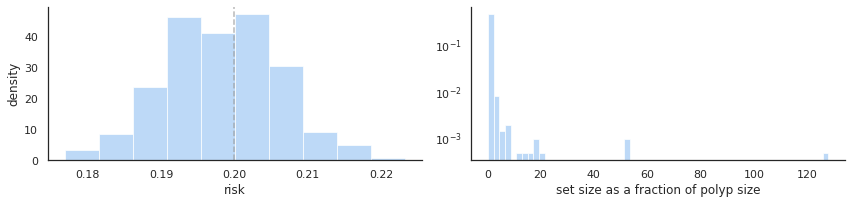

In [31]:
with torch.no_grad():
        sns.set(palette='pastel', font='serif')
        sns.set_style('white')
        fix_randomness()

        cache_path = './.cache/'
        output_dir = 'outputs/histograms/'
        pathlib.Path(cache_path).mkdir(parents=True, exist_ok=True)
        pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)

        num_trials = 1000
        num_calib = 1000
        num_lam = 1000
        alpha = 0.2
        lambdas_example_table = np.linspace(-1,0,1000)

        df = experiment(patch_gt_accum, patch_pred_accum, alpha, num_trials, num_calib, num_lam, output_dir, lambdas_example_table)
        plot_histograms(df, alpha, output_dir)


(array([  1.,   0.,   0.,   0.,   3.,   0.,   0.,   0.,   8.,   0.,   0.,
          0.,  22.,   0.,   0.,   0.,   0.,  36.,   0.,   0.,   0.,  73.,
          0.,   0.,   0., 111.,   0.,   0.,   0., 176.,   0.,   0.,   0.,
          0., 171.,   0.,   0.,   0., 161.,   0.,   0.,   0., 114.,   0.,
          0.,   0.,   0.,  69.,   0.,   0.,   0.,  40.,   0.,   0.,   0.,
         13.,   0.,   0.,   0.,   2.]),
 array([-0.05405405, -0.05382049, -0.05358692, -0.05335335, -0.05311979,
        -0.05288622, -0.05265265, -0.05241909, -0.05218552, -0.05195195,
        -0.05171839, -0.05148482, -0.05125125, -0.05101768, -0.05078412,
        -0.05055055, -0.05031698, -0.05008342, -0.04984985, -0.04961628,
        -0.04938272, -0.04914915, -0.04891558, -0.04868202, -0.04844845,
        -0.04821488, -0.04798131, -0.04774775, -0.04751418, -0.04728061,
        -0.04704705, -0.04681348, -0.04657991, -0.04634635, -0.04611278,
        -0.04587921, -0.04564565, -0.04541208, -0.04517851, -0.04494494,
      

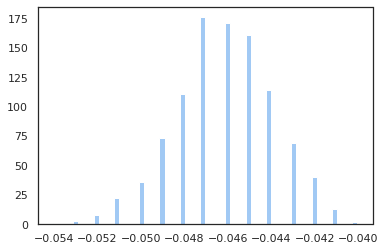

In [32]:
plt.hist(df['$\hat{\lambda}$'],bins=60)
# 

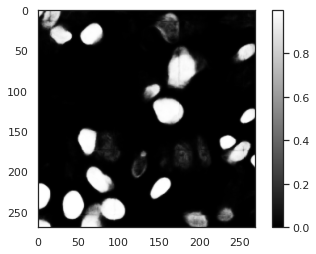

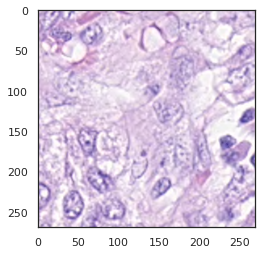

In [33]:
in_dex = 120
plt.imshow(patch_pred_accum[in_dex],cmap='gray')
plt.colorbar()
plt.figure()
plt.imshow(patch_img_accum[in_dex])

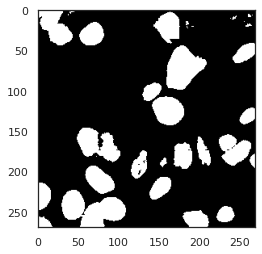

In [35]:
plt.imshow(patch_pred_accum[in_dex]>(-df['$\hat{\lambda}$'].mean()),cmap='gray')

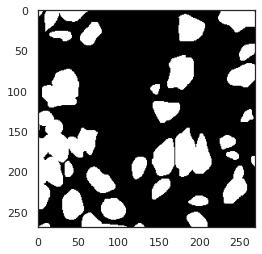

In [34]:
plt.imshow(patch_gt_accum[in_dex],cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


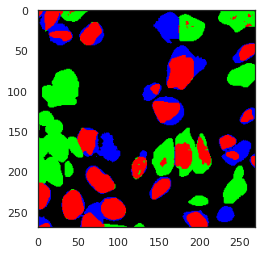

In [36]:
final_ = np.array(torch.ones(patch_gt_accum.shape[-2],patch_gt_accum.shape[-1],3))
pred = np.array(patch_pred_accum[in_dex]>(-df['$\hat{\lambda}$'].mean()))
gt_ = np.array(patch_gt_accum[in_dex]>0)
final_[:,:,0] = (pred & gt_) * 255
final_[:,:,1] = ((pred & gt_) ^ (gt_)) * 255
final_[:,:,2] = ((pred & gt_) ^ (pred)) * 255
plt.imshow(final_)
# plt.imshow()

In [ ]:
gt_

In [39]:
metrics = lambda pred,gt_: ((pred & gt_).sum(),((pred & gt_) ^ (gt_)).sum(),\
                               ((pred & gt_) ^ (pred)).sum(), (~pred & ~gt_).sum())

In [40]:
pred = np.array(patch_pred_accum>(-df['$\hat{\lambda}$'].mean()))
gt_ = np.array(patch_gt_accum>0)
TP_FN_FP_TN=metrics(pred,gt_)
FNR = TP_FN_FP_TN[1]*100/(TP_FN_FP_TN[1]+TP_FN_FP_TN[0])
FPR = TP_FN_FP_TN[2]*100/(TP_FN_FP_TN[2]+TP_FN_FP_TN[3])
FPR,FNR

(8.161337015176638, 19.024535475976737)

In [41]:
pred = np.array(patch_pred_accum>0.5)
gt_ = np.array(patch_gt_accum>0)
TP_FN_FP_TN=metrics(pred,gt_)
FNR = TP_FN_FP_TN[1]*100/(TP_FN_FP_TN[1]+TP_FN_FP_TN[0])
FPR = TP_FN_FP_TN[2]*100/(TP_FN_FP_TN[2]+TP_FN_FP_TN[3])
FPR,FNR

(2.5110042363958174, 38.56661661741196)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


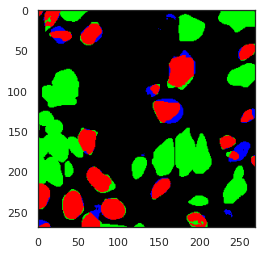

In [42]:
final_ = np.array(torch.ones(patch_gt_accum.shape[-2],patch_gt_accum.shape[-1],3))
pred = np.array(patch_pred_accum[in_dex]>0.5)
gt_ = np.array(patch_gt_accum[in_dex]>0)
final_[:,:,0] = (pred & gt_) * 255
final_[:,:,1] = ((pred & gt_) ^ (gt_)) * 255
final_[:,:,2] = ((pred & gt_) ^ (pred)) * 255
plt.imshow(final_)

In [45]:
loss = np.load('./.cache/-1.0_0.0_1000_example_loss_table.npy')

In [46]:
print(loss.shape)

(1663, 1000)


In [48]:
print(loss[0])

[1.         1.         1.         1.         1.         1.
 0.99983974 0.99935897 0.99807692 0.99527244 0.99286859 0.98934295
 0.98397436 0.97980769 0.97171474 0.9625     0.95304487 0.94302885
 0.9349359  0.92740385 0.92051282 0.91153846 0.90176282 0.89326923
 0.88677885 0.88100962 0.875      0.87011218 0.86394231 0.85673077
 0.85176282 0.84655449 0.84326923 0.83934295 0.83549679 0.83261218
 0.82964744 0.82652244 0.82475962 0.82203526 0.81987179 0.81722756
 0.81402244 0.8125     0.81009615 0.80921474 0.80793269 0.80721154
 0.80536859 0.80344551 0.80112179 0.80032051 0.79695513 0.79639423
 0.79591346 0.79407051 0.79230769 0.79182692 0.78990385 0.78894231
 0.78717949 0.78613782 0.78397436 0.78301282 0.78213141 0.78100962
 0.7806891  0.77972756 0.77908654 0.77772436 0.77740385 0.77596154
 0.77483974 0.77379808 0.77219551 0.77163462 0.77099359 0.7693109
 0.76786859 0.76642628 0.76482372 0.76402244 0.76241987 0.76065705
 0.76001603 0.75921474 0.75769231 0.75737179 0.75560897 0.75416667
 0.7

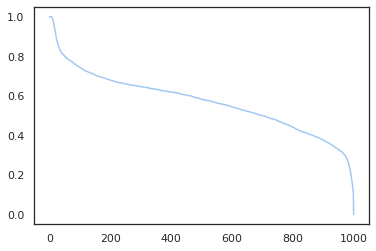

In [49]:
plt.plot(loss[0])